# Test trading

In [94]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import os
import pickle
from numba import njit
from functools import reduce

import matplotlib.cm as cm
import statsmodels as sm
import statsmodels.tsa.stattools as ts

from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from pykalman import KalmanFilter

from statsmodels.tsa.stattools import coint

from scipy import stats
import itertools
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [23]:
# Retrieve intraday price data and combine them into a DataFrame.
# 1. Load downloaded prices from folder into a list of dataframes.
folder_path = "STATICS"
file_names  = os.listdir(folder_path)
tickers     = [name.split('.')[0] for name in file_names]
df_list     = [pd.read_csv(os.path.join(folder_path, name)) for name in file_names]

# 2. Replace the closing price column name by the ticker.
for i in range(len(df_list)):
    df_list[i].rename(columns={'close': tickers[i]}, inplace=True)

# 3. Merge all price dataframes. Extract roughly the first 70% data.
df  = reduce(lambda x, y: pd.merge(x, y, on='date'), df_list)
idx = "2019-10-01"
df_test = df[df.date>=idx]
df  = df[df.date<idx]

# 4. correlated pairs sorted by cointegration p-value
N=20
with open("top{}correlatedpairs.p".format(N),"rb") as f:
    pair_lst=pickle.load(f)

In [102]:
# observation matrix

stock1=df[pair_lst[0][0]].values
stock2=df[pair_lst[0][1]].values

obs_mat = np.vstack([stock2,
                     np.ones(stock2.shape)]).T[:, np.newaxis]

delta = 1e-5 # accuracy
trans_cov = delta / (1 - delta) * np.eye(2)

kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # 2d, a pair, x/y
                  transition_matrices=np.eye(2),
                  observation_matrices=obs_mat,
                em_vars=['transition_covariance', 'observation_covariance','initial_state_mean','initial_state_covariance'])

%time state_means, state_covs = kf.em(stock1, n_iter=10).smooth(stock1)

Wall time: 5min 37s


In [108]:
kf_params={'transition_covariance':kf.transition_covariance,'observation_covariance':kf.observation_covariance,
           'initial_state_mean':state_means[-1],'initial_state_covariance':state_covs[-1]}

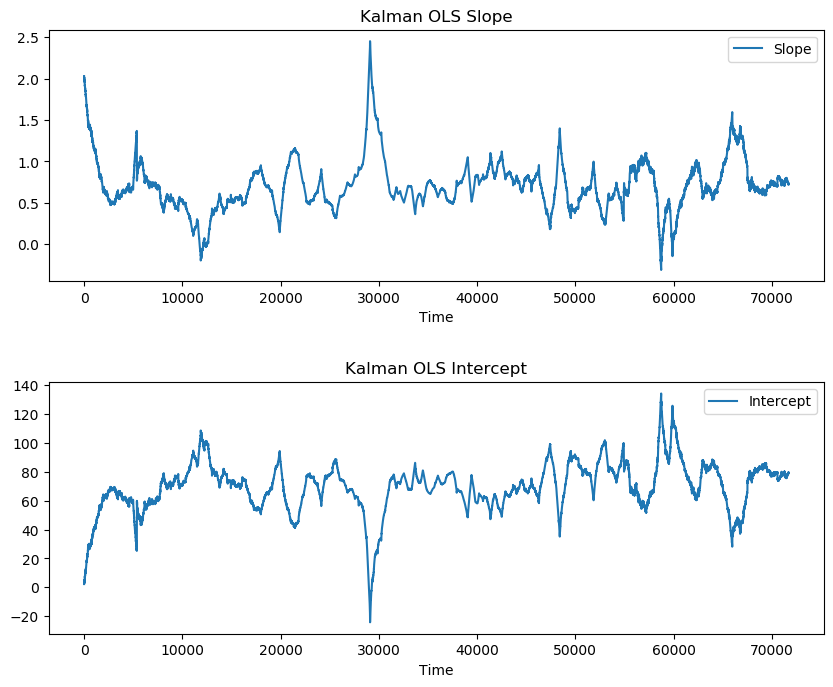

In [109]:
plt.rcParams['figure.dpi'] = 100

fig, (ax1, ax2) = plt.subplots(2,1, sharex=False,figsize=(10,8))
'plot kalman OLS coefficients: slope'
ax1.set_title('Kalman OLS Slope')
ax1.set_xlabel('Time')
ax1.plot(state_means[:,0], label = 'Slope')
ax1.legend()

ax2.set_title('Kalman OLS Intercept')
ax2.set_xlabel('Time')
ax2.plot(state_means[:,1], label = 'Intercept')
ax2.legend()

plt.subplots_adjust(wspace = 1, hspace=0.4)
plt.show()

In [110]:
# Simple OLS
model = LinearRegression()
model.fit(stock2.reshape(-1, 1), stock1)
OLS_params = {"slope":model.coef_[0], "intercept":model.intercept_}
OLS_params

{'slope': 2.1808521820536657, 'intercept': -9.200346727061387}

In [111]:
'define moving average and rolling std of data series with time period t'
@njit
def MVaverage(a, t):
    # a is an array of a vector of data
    # t is the looking back period
    i = a.shape[0]
    j = 0
    mv_t = np.zeros(i-t+1)  # moving average of data interval with period t
    std_t = np.zeros(i-t+1) # std of data interval with period t
    while i>(t-1):
        mv_t[j] = np.mean(a[j:(j+t)])
        std_t[j] = np.std(a[j:(j+t)])
        j += 1
        i -= 1
    return mv_t, std_t

'define bollinger band function to calculate Bollinger band width'
def BBand(a, t, const):
    # a is an array of a vector of data
    # t is the looking back period
    # const is the number of std away from the moving average
    BollingerBand = []
    a=np.asarray(a)
    mv, std = MVaverage(a, t)
    LowerBand = np.subtract(mv, const*std)
    UpperBand = np.add(mv, const*std)
    BollingerBand.append([LowerBand, UpperBand])
    return mv, BollingerBand

'define function to calculate maximum drawdown'
@njit
def MaxDrawdown(Ret_Cum):
    # ret_cum also can be portfolio position series
    Ret_Cum=np.asarray(Ret_Cum)
    ContVal = np.zeros(Ret_Cum.shape[0])
    MaxDD = np.zeros(Ret_Cum.shape[0])
    for i in range(Ret_Cum.shape[0]):
        if i == 0:
            if Ret_Cum[i] < 0:
                ContVal[i] = Ret_Cum[i]
            else:
                ContVal[i] = 0
        else:
            ContVal[i] = Ret_Cum[i] - np.max(Ret_Cum[0:(i+1)])
        MaxDD[i] = np.min(ContVal[0:(i+1)])
    return MaxDD


'design the black box of moving average trading strategy'
'with bollinger band'
def BBTrading(capital, stock_1, stock_2, t, const, stop_loss, KF, kf_params = None, OLS_params = None):
    # a is an array of a vector of data
    # t is the looking back period
    # const is the number of std away from the moving average
    # stop_loss: amount of loss we take (eg. 0.2*capital)
    # KalmanFilter: True or False, whether use Kalman Filter, default is False
    
    if KF==True:
        obs_mat = np.vstack([stock_2,
                             np.ones(stock_2.shape)]).T[:, np.newaxis]
        delta = 1e-5
        trans_cov = delta / (1 - delta) * np.eye(2)
        kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # 2d, a pair, x/y
                  transition_matrices=np.eye(2),
                  observation_matrices=obs_mat,
                  **kf_params)
        state_means, state_covs = kf.smooth(stock_1)
        
        'generate spread based on kalman OLS'
        spread_k = stock_1 - state_means[:,0]*stock_2 - state_means[:,1]
        a = spread_k
    
    else:
        a = stock_1 - OLS_params["slope"]*stock_2 - OLS_params["intercept"]

    mv, BB = BBand(a, t, const) # moving average and bollinger band
    
    m = np.size(mv)
    Entry = np.zeros(m-1)  # entry signal
    Holding = np.zeros(m)  # holding state
    PL_Holding = np.zeros(m-1) # holding return
    PL_Cum = np.zeros(m-1) # cumulative return of trading strategy
    
    'produce entry signal'
    for i in range(m-1):
        if i == 0:
            if a[i+t]<BB[0][0][i+1] and a[i+t-1]>BB[0][0][i]:
                Entry[i] = 1
            else:
                Entry[i] = 0
        else:
            if a[i+t]<BB[0][0][i+1] and a[i+t-1]>BB[0][0][i]:
                Entry[i] = 1
            else:
                if a[i+t]>BB[0][1][i+1] and a[i+t-1]<BB[0][1][i]:
                    Entry[i] = -1
                else:
                    Entry[i] = 0
    
    'holding decision'
    for i in range(1,m,1):
        if Entry[i-1]==0:
            Holding[i] = Holding[i-1]
        else:
            if Entry[i-1] + Holding[i-1] == 0:
                Holding[i]=0
            else:
                if np.abs(Entry[i-1]+Holding[i-1])==1:
                    Holding[i] = Entry[i-1] + Holding[i-1]
                else:
                    Holding[i] = Holding[i-1]
           
    PL_Holding = np.multiply(Holding[1:], a[(t):])*(-1) * (capital/stock_1[t])
    
    commission = Entry * (4.95 + 0.0001 * capital)*2
    PL_Holding = PL_Holding - commission 
    
    'Calculate cumulative P/L'
    for i in range(np.size(PL_Holding)):
        if i ==0:
            PL_Cum[i] = PL_Holding[0]
        else:
            PL_Cum[i] = PL_Cum[i-1]  + PL_Holding[i]
    
 
    if np.min(PL_Cum) < (-stop_loss * capital):
        po = np.min(np.where(PL_Cum < (-stop_loss*capital)))
        PL_Cum[po:] = PL_Cum[po]

    po = np.where(PL_Cum < (stop_loss*capital))
    
    'calculate maximum drawdown'
    MaxDD = MaxDrawdown(np.asarray(PL_Cum))    

    results=[]
    results.append([a, Entry, Holding, PL_Holding, PL_Cum, MaxDD])
    
    return results

Wall time: 7.84 s
Wall time: 665 ms


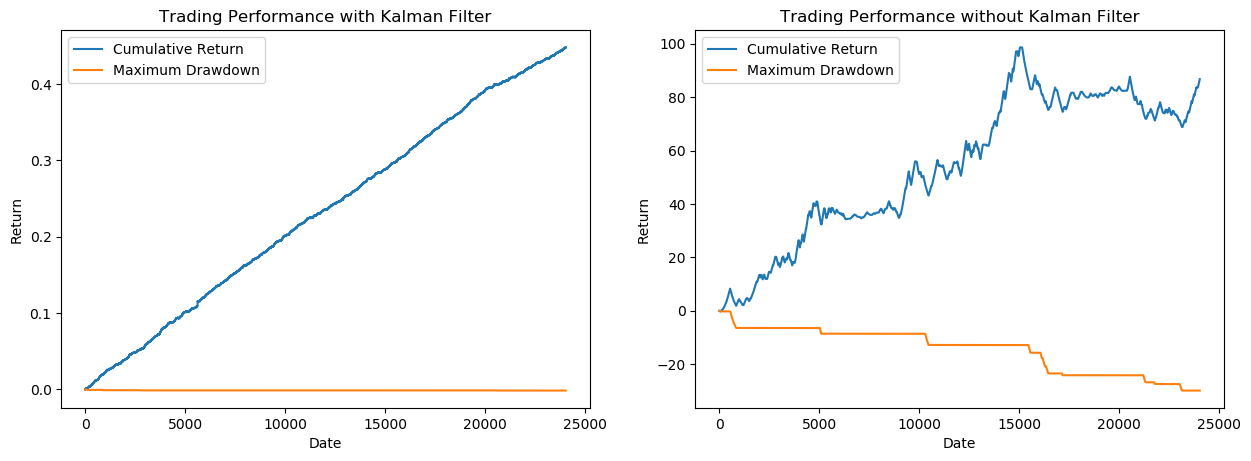

In [116]:
# one pair, trading performance
stock_1 = df_test[pair_lst[0][0]].values
stock_2 = df_test[pair_lst[0][1]].values

t = 100
const = .5
stop_loss = 0.2
capital = 1000000.

%time test_pair_T = BBTrading(capital, stock_1, stock_2, t, const, stop_loss, KF=True, kf_params = kf_params)
%time test_pair_F = BBTrading(capital, stock_1, stock_2, t, const, stop_loss, KF=False, OLS_params = OLS_params)
# return: spread, Entry, Holding, PL_Holding, PL_Cum, MaxDD

# a pair trading performance with/without Kalman Filter
fig, (ax1, ax2) = plt.subplots(1,2, sharey=False, figsize=(15,5))

ax1.set_title("Trading Performance with Kalman Filter")
ax1.set_xlabel("Date")
ax1.set_ylabel("Return")
ax1.plot(test_pair_T[0][4]/capital, label="Cumulative Return")
ax1.plot(test_pair_T[0][5]/capital, label="Maximum Drawdown")
ax1.legend()


ax2.set_title("Trading Performance without Kalman Filter")
ax2.set_xlabel("Date")
ax2.set_ylabel("Return")
ax2.plot(test_pair_F[0][4]/capital, label="Cumulative Return")
ax2.plot(test_pair_F[0][5]/capital, label="Maximum Drawdown")
ax2.legend()

plt.show()